In [ ]:
# Load library
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext, basename
from keras.models import model_from_json
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# --------- Get datasets ---------
# Natural Images - TotalText Dataset

!gdown 1bC68CzsSVTusZVvOkk7imSZSbgD1MqK2
!unzip "/content/totaltext"

Downloading...
From: https://drive.google.com/uc?id=1bC68CzsSVTusZVvOkk7imSZSbgD1MqK2
To: /content/totaltext.zip
100% 433M/433M [00:03<00:00, 122MB/s]
Archive:  /content/totaltext.zip
   creating: Images/
   creating: Images/Test/
  inflating: Images/Test/img1.jpg    
   creating: __MACOSX/
   creating: __MACOSX/Images/
   creating: __MACOSX/Images/Test/
  inflating: __MACOSX/Images/Test/._img1.jpg  
  inflating: Images/Test/img10.jpg   
  inflating: __MACOSX/Images/Test/._img10.jpg  
  inflating: Images/Test/img100.jpg  
  inflating: __MACOSX/Images/Test/._img100.jpg  
  inflating: Images/Test/img1000.jpg  
  inflating: __MACOSX/Images/Test/._img1000.jpg  
  inflating: Images/Test/img1055.jpg  
  inflating: __MACOSX/Images/Test/._img1055.jpg  
  inflating: Images/Test/img1091.jpg  
  inflating: __MACOSX/Images/Test/._img1091.jpg  
  inflating: Images/Test/img1092.jpg  
  inflating: __MACOSX/Images/Test/._img1092.jpg  
  inflating: Images/Test/img1093.jpg  
  inflating: __MACOSX/Images

In [ ]:
# Preprocess the images
def preprocess_image(image_path, resize=False, ratio=False):
  img = cv2.imread(image_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Change to grayscale
  img = ((img / np.max(img)) * 255).astype('uint8')
  if resize:
    img = cv2.resize(img, (320, 320))
  if ratio:
    (H, W) = img.shape[:2] # Get dimension
    return (img, W/float(320), H/float(320))
  else:
    return img

Found 1254 images...


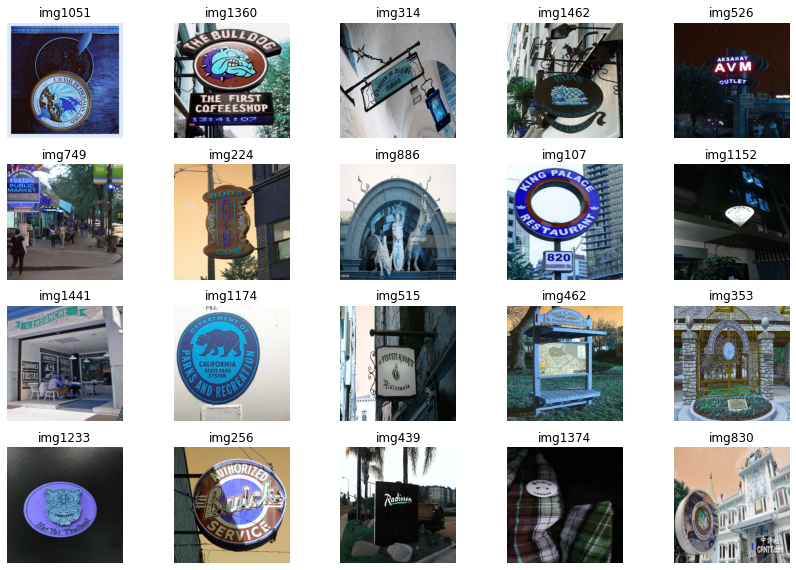

In [ ]:
# Visualize the dataset
image_paths = glob.glob("Images/Train/*.jpg")
print("Found %i images..." %(len(image_paths)))

fig = plt.figure(figsize=(12,8))
cols, rows = 5, 4 
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img, cmap=plt.cm.binary_r)

plt.tight_layout(True)
plt.show()

In [ ]:
# Get the EAST Frozen model
!wget https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1 
!tar -xvzf frozen_east_text_detection.tar.gz?dl=1

--2022-05-30 03:50:34--  https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz [following]
--2022-05-30 03:50:34--  https://www.dropbox.com/s/dl/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7fefcb6007502371adff548d6b.dl.dropboxusercontent.com/cd/0/get/BmMu5xCufSUKP_prD87Vej8XFM3VZNPuGWy9MHfVmGFCDw4zH3ArSouhIBsz6Zm5hLzghGQiC4ZkWkN222MR6qKy37U9K7aE9RFPm9MTdr3Ea8sBgPyZ3hRHXQ66Nzk1xAO97JB0uF9-00BBuaY0XKC_NtsL2fKtbY_EBmNtnpTp8Q/file?dl=1# [following]
--2022-05-30 03:50:35--  https://uc7fefcb6007502371adff548d6b.dl.dropboxusercontent.com/cd/0/get/BmM

In [ ]:
# Detect the Text
from imutils.object_detection import non_max_suppression
#import time
def detect_text(image_path):
  image = cv2.imread(image_path)
  print(image.shape, type(img), img.dtype)

  (image, rW, rH) = preprocess_image(image_path, True, True)
  print(image.shape, type(img), img.dtype)
  (height, width) = image.shape[:2] 
  orig = image.copy()

  layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

  net = cv2.dnn.readNet('./frozen_east_text_detection.pb')
  blob = cv2.dnn.blobFromImage(image, 1.0, (width, height), (123.68, 116.78, 103.94), swapRB=True, crop=False)

  #start = time.time()
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  #end = time.time()

  (numRows, numCols) = scores.shape[2:4]
  rects, confidences = [], []

  for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        if scoresData[x] < 0.5:
            continue

        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

  boxes = non_max_suppression(np.array(rects), probs=confidences)
  #print(np.array(rects), boxes)
  for (startX, startY, endX, endY) in boxes:
      startX = int(startX * rW)
      startY = int(startY * rH)
      endX = int(endX * rW)
      endY = int(endY * rH)

      cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
      
  return orig

(960, 1280, 3) <class 'numpy.ndarray'> uint8
(320, 320, 3) <class 'numpy.ndarray'> uint8


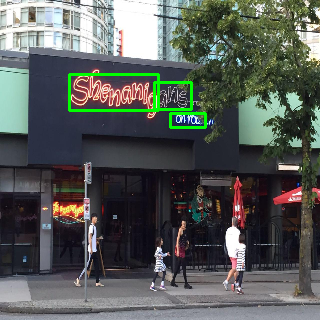

In [ ]:
i=101
img = detect_text(image_paths[i])

from google.colab.patches import cv2_imshow
cv2_imshow(img)